___
# Ciência dos Dados - PROJETO 2

___
## Nome 1: Alexandre Edington

## Nome 2: Bruno Cury


___

___

## 1. Problema

O Classificador Naive-Bayes, o qual se baseia no uso do teorema de Bayes, é largamente utilizado em filtros anti-spam de e-mails. O classificador permite calcular qual a probabilidade de uma mensagem ser SPAM considerando as palavras em seu conteúdo e, de forma complementar, permite calcular a probabilidade de uma mensagem ser HAM dada as palavras descritas na mensagem.

Para realizar o MVP (minimum viable product) do projeto, você precisa programar uma versão do classificador que "aprende" o que é uma mensagem SPAM considerando uma base de treinamento e comparar o desempenho dos resultados com uma base de testes. 


___
## 2. Separação da base de dados em Treinamento e Teste

A base de dados deve ser separada em duas partes, aleatoriamente, considerando: 
    
    75% dos dados para a parte Treinamento; e
    25% dos dados para a parte Teste.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

dados = pd.read_excel('spamham.xlsx',sep=',') 
pd.options.mode.chained_assignment = None

Esperamos trabalhar no diretório
C:\Users\alexa\OneDrive\Área de Trabalho\Dados2018\Projeto2


Começamos o trabalho na célula abaixo, onde vamos primeiro filtrar a base de dados, tirando todos os carácteres que não agregarão valor à nossa análise. Após ter realizado a limpeza dos dados partiremos para a separação dos dados, que deve ser feita aleatoriamente, com proporção de três quartos do dataframe indo para o Treinamento e um quarto indo para o Teste.

In [3]:
dados["Email"] = dados.Email.str.replace(","," ")
dados["Email"] = dados.Email.str.replace("$"," ")
dados["Email"] = dados.Email.str.replace("+"," ")
dados["Email"] = dados.Email.str.replace("-"," ")
dados["Email"] = dados.Email.str.replace("="," ")
dados["Email"] = dados.Email.str.replace("%"," ")
dados["Email"] = dados.Email.str.replace("*"," ")
dados["Email"] = dados.Email.str.replace("/"," ")
dados["Email"] = dados.Email.str.replace("/n"," ")
dados["Email"] = dados.Email.str.replace(":"," ")
dados["Email"] = dados.Email.str.replace("("," ")
dados["Email"] = dados.Email.str.replace(")"," ")
dados["Email"] = dados.Email.str.replace("~"," ")
dados["Email"] = dados.Email.str.replace("["," ")
dados["Email"] = dados.Email.str.replace("]"," ")
dados["Email"] = dados.Email.str.replace("."," ")
dados["Email"] = dados.Email.str.replace(";"," ")
dados["Email"] = dados.Email.str.replace("_"," ")
dados["Email"] = dados.Email.str.replace("  "," ")
dados["Email"] = dados.Email.str.lower()
dados["Email"] = dados.Email.str.split()



Treinamento = dados.sample(n=None, frac=0.75, replace=False).reset_index()
Teste = dados.sample(n=None, frac=0.25, replace=False).reset_index()

Treinamento = Treinamento.drop(["index"],axis = 1)
Teste = Teste.drop(["index"],axis = 1)

___
## 3. Classificador Naive-Bayes

In [4]:
Treinamento["Class"].value_counts()

ham     3613
spam     566
Name: Class, dtype: int64

Começamos agora a estruturação de nosso algoritmo Naive Bayes, para isso iniciaremos calculando as probabilidades marginais e condicionais necessárias para classificar uma nova mensagem.

In [5]:
PHAM = (Treinamento["Class"].value_counts()["ham"]/4179)*100
print("A probabilidade de receber um ham é:  "+str(PHAM))

PSPAM = (Treinamento["Class"].value_counts()["spam"]/4179)*100
print("A probabilidade de receber um spam é:  " +str(PSPAM))

A probabilidade de receber um ham é:  86.45608997367792
A probabilidade de receber um spam é:  13.543910026322086


Como não estamos trabalhando com números, e sim frases, temos de transformar estas frases em informações que possam ser utilizadas em nosso algoritmo, fazendo o papel de nossas "features". Vamos analisar as frases ignorando a ordem e construção das mesmas, tratando cada email como um conjunto das palavras que ele contém.

Para isso na célula abaixo estamos mapeando, por meio de um dicionário e contadores, quantas vezes uma palavra aparece em e-mails que são classificados como spam ou ham, individualmente. Ao final teremos a informação exata de quantas vezes cada palavra apareceu em Spams ou em Hams, com cada palavra assumindo o papel das "Keys" e os valores dentro delas representando a quantidade de vezes que ela aparece em e-mails hams e e-mails Spams, juntamente com a probabilidade de ela aparecer em e-mails ham ou spam, respectivamente.

In [6]:
dicti = {} #dicti["palavra"]= ham,spam,pham,pspam

for i in range(4179):
    for palavra in Treinamento.Email[i]:
        if Treinamento.Class[i] == "ham":
            if palavra not in dicti:
                dicti[palavra] = 1,0
            else:
                tempa=dicti[palavra][0]
                tempb=dicti[palavra][1]
                dicti[palavra]=tempa+1,tempb
        else:
            if palavra not in dicti:
                dicti[palavra] = 0,1
            else:
                tempa=dicti[palavra][0]
                tempb=dicti[palavra][1]
                dicti[palavra]=tempa,tempb+1

totalspam=0
totalham=0
for i in dicti:
    totalham+=dicti[i][0]
    totalspam+=dicti[i][1]
#print(totalham, totalspam)
for i in dicti:
    tempa=dicti[i][0]
    tempb=dicti[i][1]
    pham=(tempa+1)/((totalham*2)+totalspam)
    pspam=(tempb+1)/((totalspam*2)+totalham)
    dicti[i]=tempa,tempb,pham,pspam

pspamtotal=565/(3616+565)
phamtotal=3616/(3616+565)

Agora o que resta fazer é calcular a probabilidade de cada frase ser Spam ou Ham por meio da probabilidade de cada palavra estar em Spam ou Ham, porém, nesta etapa encontramos um problema, se a probabilidade de uma palavra estar dentro de Spam ou Ham for zero isso irá zerar todo o nosso cálculo, já que só estamos fazendo multiplicações e divisões. Para resolver este problema usamos um princípio chamado "Laplace Smoothing", onde adicionamos 1 ao numerador e a somatória de todas as palavras possíveis no denominador, excluindo a chance de alguma probabilidade resultar em 0.

Resolvendo este empecilho, precisamos agora multiplicar todas as probabilidades e compara-las para verificar qual é maior e plota-la como resposta.


In [7]:
def naive(frase):
    PS = PSPAM
    PH = PHAM
    for palavra in frase:
        if palavra in dicti:
            PS*= dicti[palavra][3]
            PH*= dicti[palavra][2]
        else:
            PS = (PS+1)/8632
            PH = (PH+1)/8632
    if PS>PH:
        return("spam")
    else:
        return("ham")

Até o momento estávamos usando o dataframe "Treinamento" para construir nosso mecanismo, toda via, o algoritmo agora está pronto e devemos testa-lo. Para fazê-lo basta aplicar a função criada (naive) no dataframe "Teste" e comparar as respostas do algoritmo com as respostas dadas a priori.
Fizemos isso adicionando uma nova coluna ao dataframe, ao lado da coluna de classificação, contendo a classificação do algoritmo, e por meio da análise e comparação das respostas conseguimos chegar nas medidas pedidas (% de negativos verdadeiros, % de positivos verdadeiros, % de positivos falsos e % de negativos falsos).


In [8]:
def Tester(Teste):
    frase = Teste.Email
    return naive(frase)

T = Teste.apply(Tester,axis=1)
Teste["Naive"] = T

In [9]:
Teste.loc[(Teste.Class == "ham") & (Teste.Naive == "ham"),"Correcao"] = "negativo verdadeiro"
Teste.loc[(Teste.Class == "spam") & (Teste.Naive == "spam"),"Correcao"] = "positivo verdadeiro"
Teste.loc[(Teste.Class == "spam") & (Teste.Naive == "ham"),"Correcao"] = "positivo falso"
Teste.loc[(Teste.Class == "ham") & (Teste.Naive == "spam"),"Correcao"] = "negativo falso"


Teste_Neg_Ver = Teste.Correcao[Teste.Correcao == "negativo verdadeiro"].value_counts()
Teste_Pos_Ver = Teste.Correcao[Teste.Correcao == "positivo verdadeiro"].value_counts()
Teste_Pos_Fal = Teste.Correcao[Teste.Correcao == "positivo falso"].value_counts()
Teste_Neg_Fal = Teste.Correcao[Teste.Correcao == "negativo falso"].value_counts()

P_Neg_Ver = (Teste_Neg_Ver/len(Teste)*100)
P_Pos_Ver = (Teste_Pos_Ver/len(Teste)*100)
P_Pos_Fal = (Teste_Pos_Fal/len(Teste)*100)
P_Neg_Fal = (Teste_Neg_Fal/len(Teste)*100)

print("A probabilidade de ocorrer um negativo verdadeiro é:  " +str(P_Neg_Ver))
print("A probabilidade de ocorrer um positivo verdadeiro é:  " +str(P_Pos_Ver))
print("A probabilidade de ocorrer um positivo falso é:  " +str(P_Pos_Fal))
print("A probabilidade de ocorrer um negativo falso é:  " +str(P_Neg_Fal))

A probabilidade de ocorrer um negativo verdadeiro é:  negativo verdadeiro    86.001436
Name: Correcao, dtype: float64
A probabilidade de ocorrer um positivo verdadeiro é:  positivo verdadeiro    11.270639
Name: Correcao, dtype: float64
A probabilidade de ocorrer um positivo falso é:  positivo falso    2.440775
Name: Correcao, dtype: float64
A probabilidade de ocorrer um negativo falso é:  negativo falso    0.28715
Name: Correcao, dtype: float64


As medidas acima indicam o quão preciso é o seu classificador naive bayes. O teste nos retornou uma probabilidade altíssima de negativos verdadeiros, o que significa que estamos realmente acertando quando uma mensagem não é Spam, os positivos verdadeiros têm a segunda probabilidade mais alta, esta medida indica que marcamos uma mensagem como Spam e ela realmente era um Spam. As outras duas medidas indicam o quanto nosso algoritmo está errando na classificação dos e-mails, porém, o erro mais grave (negativos falsos) tem uma probabilidade de apenas 0.3% o que indica que o nosso algoritmo é um bom classificador.

___
## 4. Curva ROC

Para decidirmos o output do nosso algoritmo naive bayes comparamos as probabilidades do e-mail ser spam e ham e retornamos a maior, não obstante, em comparações de probabilidades próximas como 49% e 51% talvez a comparação de quem tem a maior probabilidade não seja a mais adequada, essa probabilidade é chamada de ponto de corte.

A curva ROC vem como uma alternativa para descobrir o melhor ponto de corte possível. Começamos rodando o algoritmo para probabilidades de 1% a 100%, e a cada vez que rodamos o código extraímos duas medidas: Sensibilidade e Especificidade, compostas respectivamente, pelos acertos positivos sobre o total de acertos e pelos acertos negativos sobre o total de negativos.

Os valores de Sensibilidade e Especificidade podem então serem dispostos em um gráfico denominado curva ROC, que apresenta no eixo das ordenadas os valores de sensibilidade e nas abscissas o complemento da especificidade, ou seja, o valor (1-especificidade).

O Classificador perfeito apresentará uma reta alocada horizontalmente no topo do gráfico, toda via, este é um resultado dificílimo de ser alcançado. Um bom classificador irá mostrar uma linha entre a linha diagonal (que indica uma classificação aleatória como cara ou coroa) e a linha perfeita e quanto mais longe da linha diagonal, melhor o seu classificador.

Para encontrar o melhor ponto de corte usamos o valor de (Phi) assim, podemos obter o limiar que apresente a melhor combinação de valores de especificidade e sensibilidade para o sistema.


In [10]:
def naive2(frase,): #segundo naive especificamente para a curva ROC
    PS = PSPAM
    PH = PHAM
    for palavra in frase:
        if palavra in dicti:
            PS*= dicti[palavra][3]
            PH*= dicti[palavra][2]
        else:
            PS = (PS+1)/8632
            PH = (PH+1)/8632   
        if PS > i*(PS+PH):
            return("spam")  
        else:
            return("ham")
def Tester2(Teste):
    frase = Teste.Email
    return naive2(frase)   

In [11]:
LHAM=[] #especificidade
LSPAM=[] #sensibilidade
phi=[] # coeficiente de correlação de Matthews
for i in np.arange(0,1,0.01): 
    T = Teste.apply(Tester2,axis=1) #aplicação do Bayes2 no dataframe
    Teste["Naive"] = T
    ct=pd.crosstab(Teste.Class,Teste.Naive)
    
    if hasattr(ct,"ham") and hasattr(ct,"spam"): #teste para que a crosstab possua as duas colunas que precisa
        
        tempa=ct.ham["ham"]/(ct.ham["ham"]+ct.spam["ham"])
        tempb=ct.spam["spam"]/(ct.ham["spam"]+ct.spam["spam"])
        tempc1=(ct.spam["spam"]*ct.ham["ham"])-(ct.spam["ham"]*ct.ham["spam"])
        tempc2=(ct.spam["spam"]+ct.ham["spam"])*(ct.spam["spam"]+ct.spam["ham"])*(ct.ham["ham"]+ct.ham["spam"])*(ct.ham["ham"]+ct.spam["ham"])
        LHAM.append(1-tempa)
        LSPAM.append(tempb)
        phi.append(tempc1/math.sqrt(tempc2))
        
    elif hasattr(ct,"ham") and not hasattr(ct, "spam"):
        
            tempa=1
            tempb=0
            tempc=0
            LHAM.append(1-tempa)
            LSPAM.append(tempb)
            phi.append(tempc)
            
    elif hasattr(ct,"spam") and not hasattr(ct,"ham"):
        
            tempa=0
            tempb=1
            tempc=0
            LHAM.append(1-tempa)
            LSPAM.append(tempb)
            phi.append(tempc)

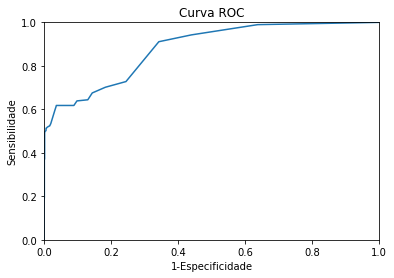

In [12]:
plt.plot(LHAM,LSPAM)
plt.axis([0,1,0,1])
plt.title("Curva ROC")
plt.xlabel("1-Especificidade")
plt.ylabel("Sensibilidade")
plt.show()

O Coeficiente de Correlação de Matthews, ou coeficiente phi, é uma medida de correlação entre duas listas de valores binários que funciona independente do tamanho das listas. Esse coeficiente pode variar entre os valores 1 e -1. 1 Significa uma correlação perfeita enquanto -1 significa uma correlção inversa, e 0 significa que as listas não possuem nenhuma correlação.

Em cada ponto da curva ele é calculado através da seguinte fórmula: φ = (VP*VN – FP*FN) / sqrt((VP + FP)*(VP + FN)*(VN + FP)*(VN + FN)) e quanto maior seu valor, melhor a avaliação do nosso Naive-Bayes para aquele ponto de corte.
Para essa curva, utilizando o coeficiente phi, pode-se afirmar que o melhor ponto de corte é:

In [13]:
print(phi.index(max(phi))/100)

0.28


___
## 5. Qualidade do Classificador alterando a base de treinamento

É razoável pensar que os dataframes utilizados até agora (Treinamento e Teste), mesmo sendo gerados aleatoriamente representam uma das muitas divisões possíveis da proporção 75% e 25% dos dados, com isso em mente vamos variar nossa base de dados aleatoriamente 2000 vezes para observar os impactos causados em nosso classificador através de um histograma.

In [14]:
PPV=[] #porcentagem de positivos verdadeiros
PNV=[] #porcentagem de negativos verdadeiros
for i in range(2000):
    
    #Separação da base de dados
    Treinamento = dados.sample(n=None, frac=0.75, replace=False).reset_index()
    Teste = dados.sample(n=None, frac=0.25, replace=False).reset_index()
    Treinamento = Treinamento.drop(["index"],axis = 1)
    Teste = Teste.drop(["index"],axis = 1)
    
    #Aplicação do Naive-Bayes
    T = Teste.apply(Tester,axis=1)
    Teste["Naive"] = T
    
    #salvando as porcentagens
    ct=pd.crosstab(Teste.Class,Teste.Naive)
    tempa=ct.spam["spam"]/(ct.spam["spam"]+ct.spam["ham"])*100
    tempb=ct.ham["ham"]/(ct.ham["ham"]+ct.ham["spam"])*100
    PPV.append(tempa)
    PNV.append(tempb)

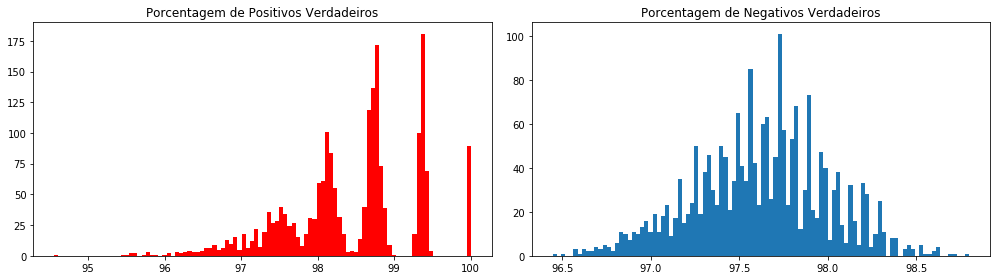

In [15]:
fig = plt.figure(figsize=(14,4))
plt.subplot(121)
plt.hist(PPV,bins=100,color="red")
plt.title("Porcentagem de Positivos Verdadeiros")

plt.subplot(122)
plt.hist(PNV,bins=100)
plt.title("Porcentagem de Negativos Verdadeiros")

plt.tight_layout()
plt.show()

In [16]:
print("A média da porcentagem de positivos verdadeiros é " + str(np.mean(PPV)))
print("A média da porcentagem de negativos verdadeiros é " + str(np.mean(PNV)))

A média da porcentagem de positivos verdadeiros é 98.42500177005005
A média da porcentagem de negativos verdadeiros é 97.62039114922598


Por intermédio dos resultados dos histogramas é razoável concluir que a média das duas porcentagens de acertos e é muito parecida, mostrando uma consistência no código. Além disso, ao rodarmos o código 2000 vezes chegamos a uma média de acertos de 97%, mostrando que fazer a base de dados múltiplas vezes o torna muito mais preciso.